In [1]:
# init

In [2]:
import re, string, unicodedata
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from wordcloud import WordCloud,STOPWORDS

from bs4 import BeautifulSoup

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer

import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer

import keras
from keras.utils import pad_sequences
from keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

import tensorflow as tf

# Dataset 1

In [3]:
data_true = pd.read_csv("Fake and real news dataset (True).csv")
data_false = pd.read_csv("Fake and real news dataset (Fake).csv")

In [4]:
data_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
data_false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
data_true['category'] = 1
data_false['category'] = 0

In [7]:
data_1 = pd.concat([data_true, data_false])
data_1.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


<AxesSubplot:xlabel='category', ylabel='count'>

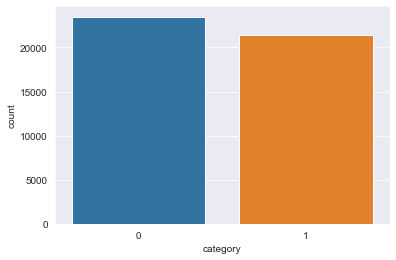

In [8]:
sns.set_style("darkgrid")
sns.countplot(x=data_1["category"])

In [9]:
data_1.isna().sum()

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [10]:
data_1.title.count()

44898

In [11]:
data_1.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

[Text(0, 0, 'politicsNews'),
 Text(1, 0, 'worldnews'),
 Text(2, 0, 'News'),
 Text(3, 0, 'politics'),
 Text(4, 0, 'Government News'),
 Text(5, 0, 'left-news'),
 Text(6, 0, 'US_News'),
 Text(7, 0, 'Middle-east')]

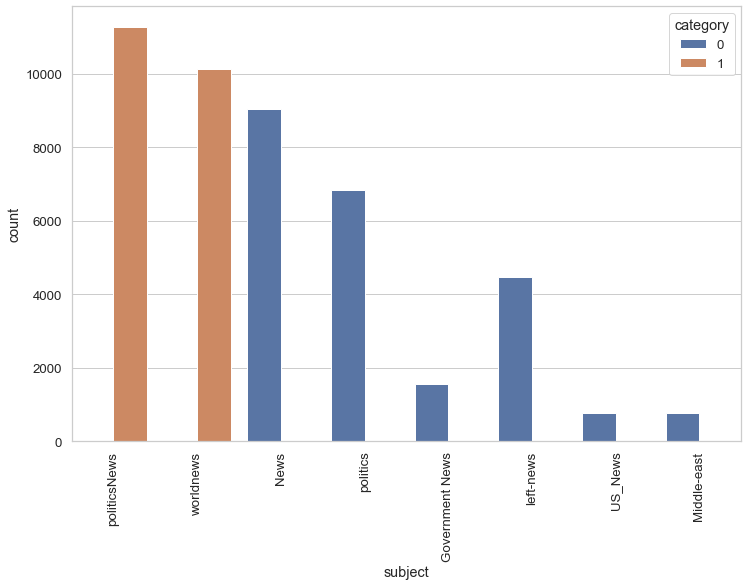

In [12]:
plt.figure(figsize = (12,8))
sns.set(style="whitegrid",font_scale=1.2)
chart = sns.countplot(x="subject", hue="category", data=data_1)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

In [13]:
data_1['text'] = data_1['text'] + " " + data_1['title']
del data_1['title']
del data_1['subject']
del data_1['date']
data_1.head()

,text,category
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


# Dataset 2

In [14]:
data_2 = pd.read_csv("Fake News.csv")
data_2.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [15]:
le = preprocessing.LabelEncoder()
le.fit(data_2.label)
data_2['category'] = le.transform(data_2.label)
data_2.head()

,Unnamed: 0,title,text,label,category
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,1


<AxesSubplot:xlabel='category', ylabel='count'>

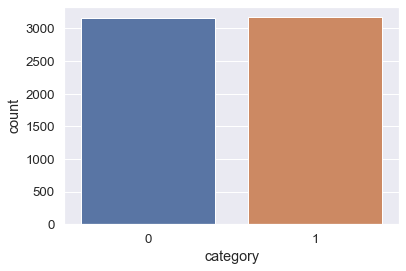

In [16]:
sns.set_style("darkgrid")
sns.countplot(x=data_2["category"])

In [17]:
data_2.isna().sum()

Unnamed: 0    0
title         0
text          0
label         0
category      0
dtype: int64

In [18]:
data_2.title.count()

6335

In [19]:
data_2['text'] = data_2['text'] + " " + data_2['title']
del data_2['Unnamed: 0']
del data_2['title']
del data_2['label']
data_2.head()

,text,category
0,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,U.S. Secretary of State John F. Kerry said Mon...,1
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,It's primary day in New York and front-runners...,1


# Dataset 3

In [20]:
data_3 = pd.read_csv("Fake News detection.csv")
data_3.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


<AxesSubplot:xlabel='Label', ylabel='count'>

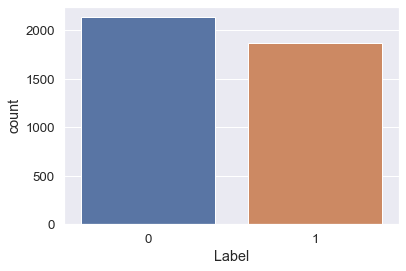

In [21]:
sns.set_style("darkgrid")
sns.countplot(x=data_3["Label"])

In [22]:
data_3.isna().sum()

URLs         0
Headline     0
Body        21
Label        0
dtype: int64

In [23]:
data_3.dropna(inplace=True)

In [24]:
data_3.isna().sum()

URLs        0
Headline    0
Body        0
Label       0
dtype: int64

In [25]:
data_3.Headline.count()

3988

In [26]:
data_3['text'] = data_3['Body'] + " " + data_3['Headline']
data_3['category'] = data_3['Label']
del data_3['Headline']
del data_3['Body']
del data_3['Label']
del data_3['URLs']
data_3.head()

,text,category
0,Image copyright Getty Images\nOn Sunday mornin...,1
1,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,The feud broke into public view last week when...,1
3,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,"Country singer Jason Aldean, who was performin...",1


# Merge

55221

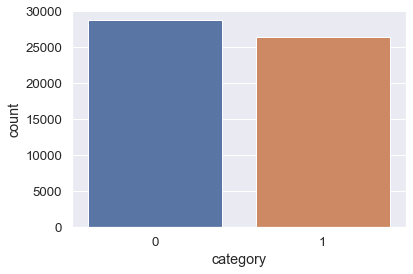

In [27]:
df = pd.concat([data_1, data_2, data_3])
sns.set_style("darkgrid")
sns.countplot(x=df["category"])
len(df)

In [28]:
df.head()

,text,category
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


# Preprocess

In [29]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andys\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
stop = set(stopwords.words("english"))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [31]:
' '.join(list(stop)[0:20]) + ' '.join(punctuation[:15])

'+ more and because aren yourself aren\'t too where theirs not off she himself myself who such once ^ t! " # $ % & \' ( ) * + , - . /'

In [32]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_between_square_brackets_2(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_between_square_brackets_2(text)
    text = remove_stopwords(text)
    return text

# Apply function on review column
df['text'] = df['text'].apply(denoise_text)

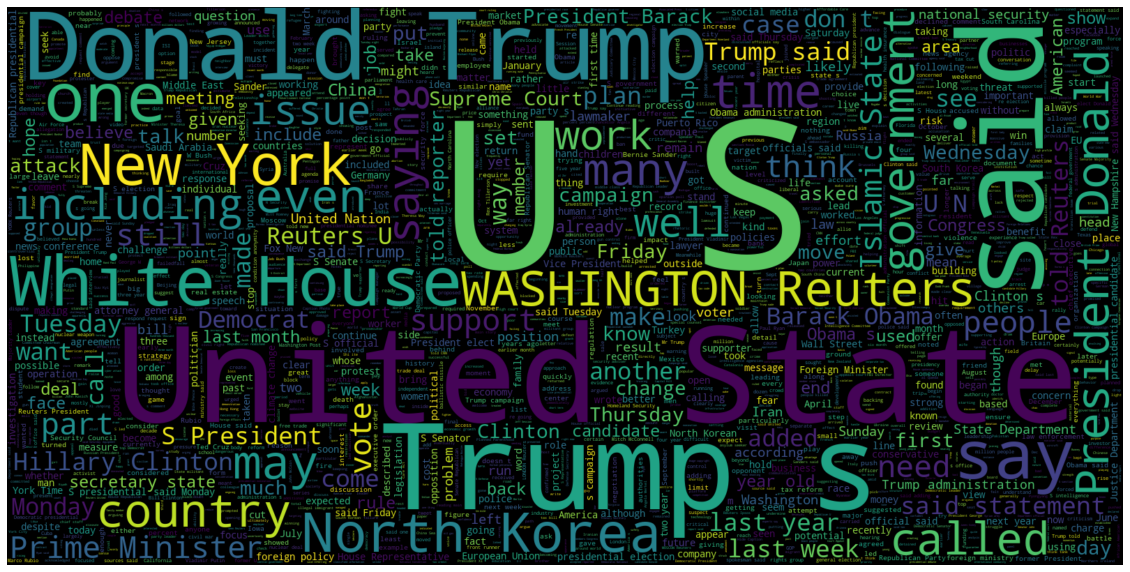

In [33]:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 1].text))
plt.axis('off')
plt.margins(0,0)
plt.imshow(wc , interpolation = 'bilinear')

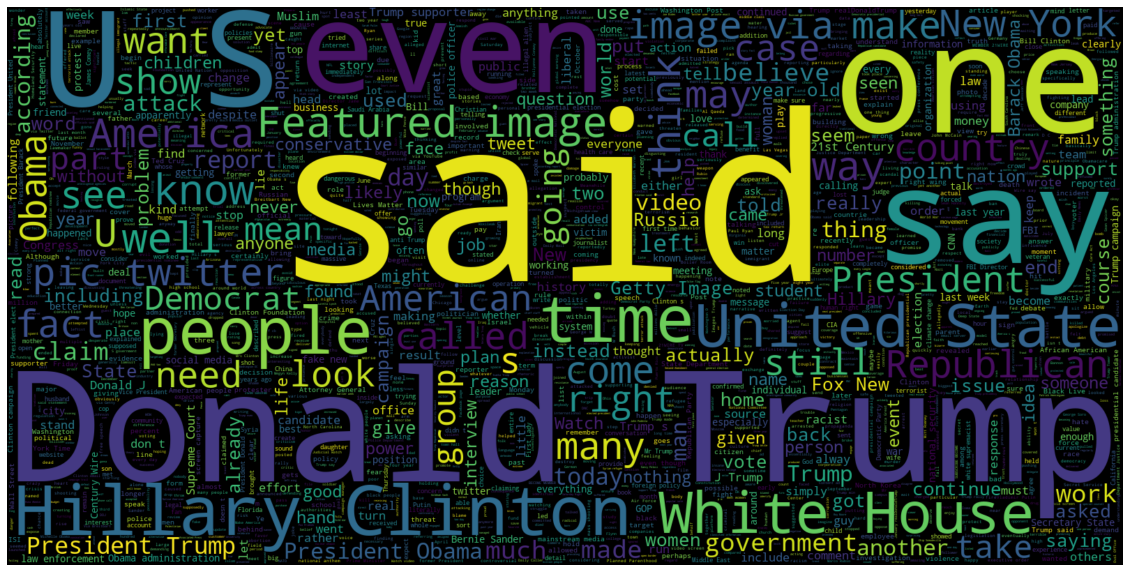

In [34]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 0].text))
plt.axis('off')
plt.margins(0,0)
plt.imshow(wc , interpolation = 'bilinear')

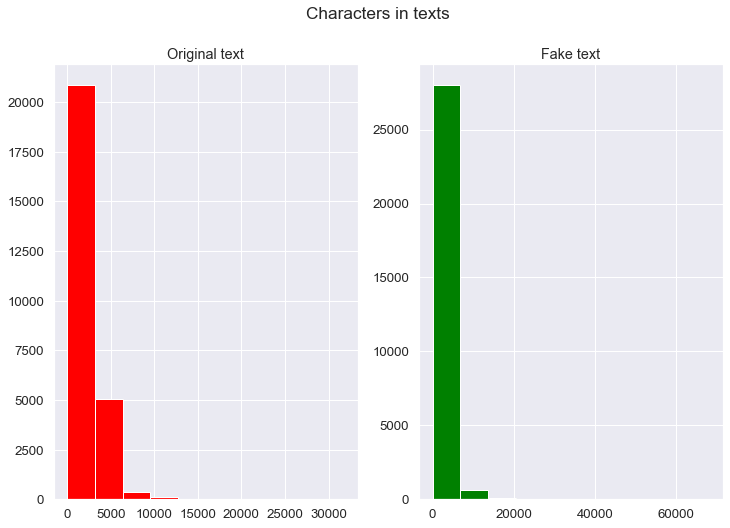

In [35]:
# Number of characters in texts

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']==1]['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=df[df['category']==0]['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Characters in texts')
plt.show()

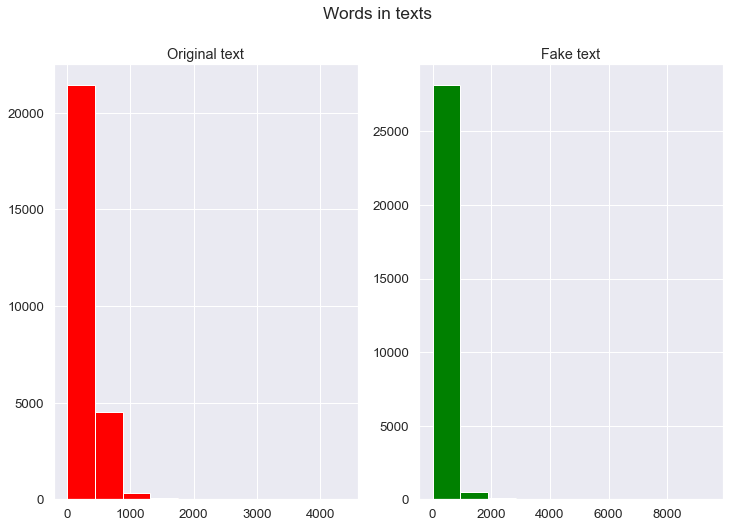

In [36]:
# Number of words in each text

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=df[df['category']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Words in texts')
plt.show()

C:\Users\andys\AppData\Local\Temp\ipykernel_16680\925472908.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
G:\Programming\python2022\venv\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
G:\Programming\python2022\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\andys\AppData\Local\Temp\ipykernel_16680\925472908.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in se

Text(0.5, 0.98, 'Average word length in each text')

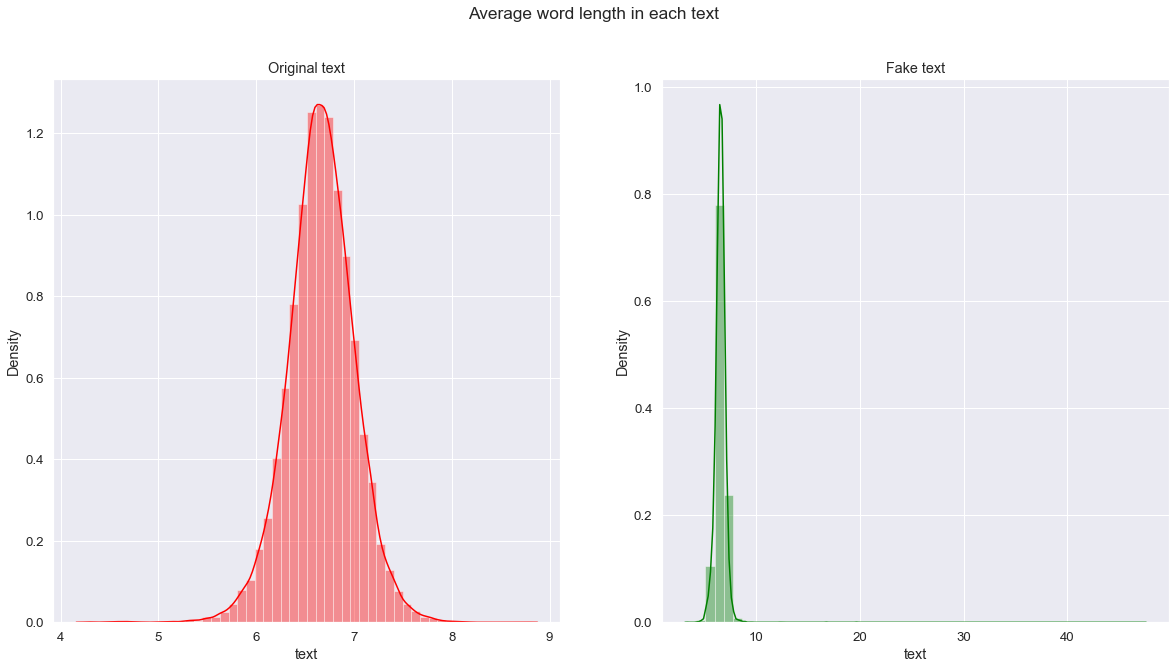

In [37]:
# Average word length in a text

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['category']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Original text')
word=df[df['category']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Fake text')
fig.suptitle('Average word length in each text')

In [38]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words

corpus = get_corpus(df.text)
corpus[:15]

['WASHINGTON',
 '(Reuters)',
 'head',
 'conservative',
 'Republican',
 'faction',
 'U.S.',
 'Congress,',
 'voted',
 'month',
 'huge',
 'expansion',
 'national',
 'debt',
 'pay']

In [39]:
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'Trump': 129418,
 'said': 112539,
 'would': 70987,
 'U.S.': 57028,
 'people': 44036,
 'one': 41713,
 'also': 41357,
 'President': 38215,
 'Clinton': 35071,
 'said.': 34102}

In [40]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<AxesSubplot:>

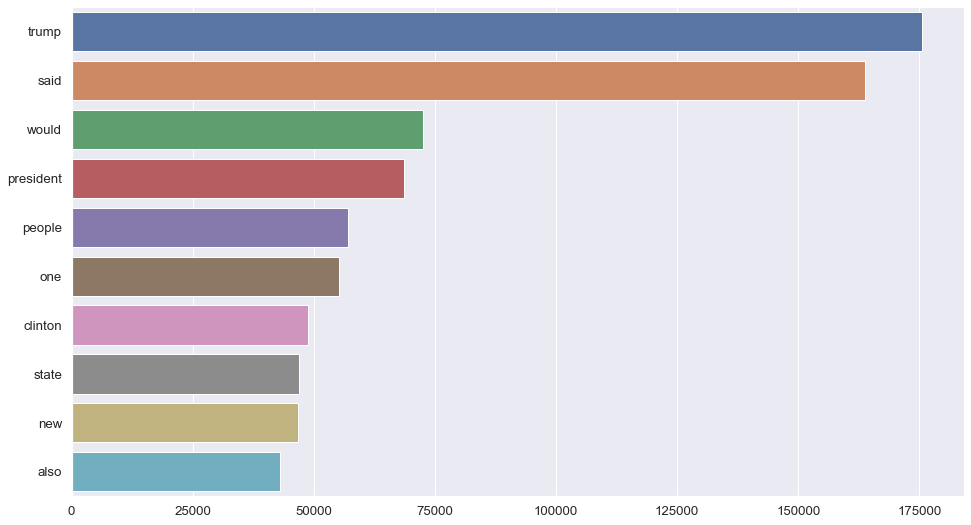

In [41]:
# Unigram Analysis

plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

<AxesSubplot:>

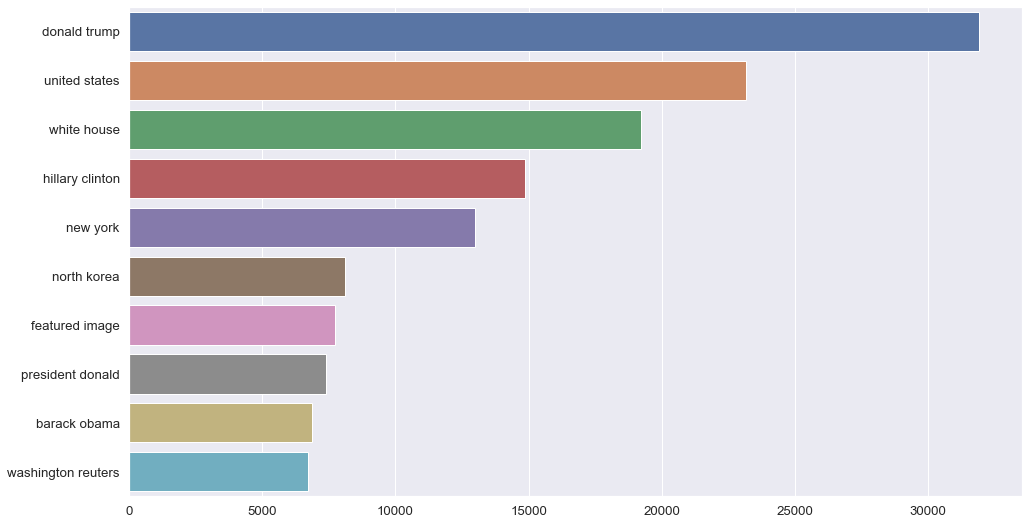

In [42]:
# Bigram Analysis

plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

<AxesSubplot:>

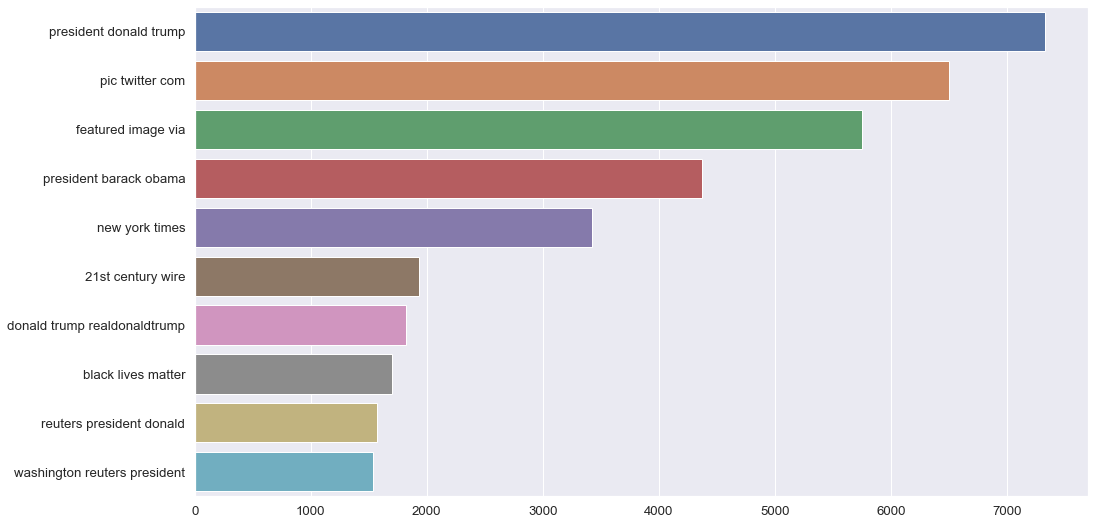

In [43]:
# Trigram Analysis

plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(df.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

In [44]:
x_train,x_test,y_train,y_test = train_test_split(df.text,df.category,random_state = 0)

len(x_train), len(x_test)

(41415, 13806)

In [45]:
max_features = 10000
maxlen = 300

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)

tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(tokenized_train, maxlen=maxlen)

tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(tokenized_test, maxlen=maxlen)

In [46]:
x_test

6957     immediate aftermath shooting Planned Parenthoo...
7663     Costco cares American workforce Republicans do...
19914    Wow wow! happens political candidates divide n...
14403    finally beaten old cranky socialist one state ...
15497    another interesting discovery story already ex...
                               ...                        
8664     MEXICO CITY (Reuters) Mexican President Enriqu...
12464    Way thank hard working campaign staff Hillary ...
2271     Inside New York's oldest bookstore Wonder List...
2805     BRUSSELS (Reuters) Russian Foreign Minister Se...
1478     wondering Sen. Lindsey Graham (R) OK. seem lat...
Name: text, Length: 13806, dtype: object

In [47]:
EMBEDDING_FILE = 'glove.twitter.27B.100d.txt'

In [48]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding='utf-8'))

In [49]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

G:\Programming\python2022\venv\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


In [50]:
embed_size = 100

In [51]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

model = Sequential([
    Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False),
    # LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25),
    LSTM(units=128 , return_sequences = True , dropout = 0.25),
    # LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1),
    LSTM(units=64 , dropout = 0.1),
    Dense(units = 32 , activation = 'relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 300, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


G:\Programming\python2022\venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [52]:
train = False

if train:
    batch_size = 256
    epochs = 5

    history = model.fit(
        x_train, y_train,
        batch_size = batch_size ,
        validation_data = (X_test,y_test) ,
        epochs = epochs ,
        callbacks = [learning_rate_reduction]
    )
else:
    pass
    # model.load_weights('weights/ckpt')
    model.load_weights('weights2/ckpt')  # no recurrent dropout

In [53]:
# model.save_weights('weights/ckpt')
# model.save_weights('weights_new/ckpt')
# model.save_weights('weights2/ckpt')  # no recurrent dropout

In [54]:
print("Accuracy of the model on Training Data is - " ,
      model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " ,
      model.evaluate(X_test,y_test)[1]*100 , "%")

1295/1295 [==============================] - 35s 18ms/step - loss: 0.0515 - accuracy: 0.9809
Accuracy of the model on Training Data is -  98.08765053749084 %
432/432 [==============================] - 8s 17ms/step - loss: 0.0747 - accuracy: 0.9705
Accuracy of the model on Testing Data is -  97.05200791358948 %


# CM test

In [56]:
preds = model.predict(X_test)
pred = (preds > 0.5).astype("int32")

print(classification_report(y_test, pred, target_names = ['Fake','Not Fake']))

              precision    recall  f1-score   support

        Fake       0.98      0.97      0.97      7227
    Not Fake       0.96      0.97      0.97      6579

    accuracy                           0.97     13806
   macro avg       0.97      0.97      0.97     13806
weighted avg       0.97      0.97      0.97     13806



Text(64.5, 0.5, 'Actual')

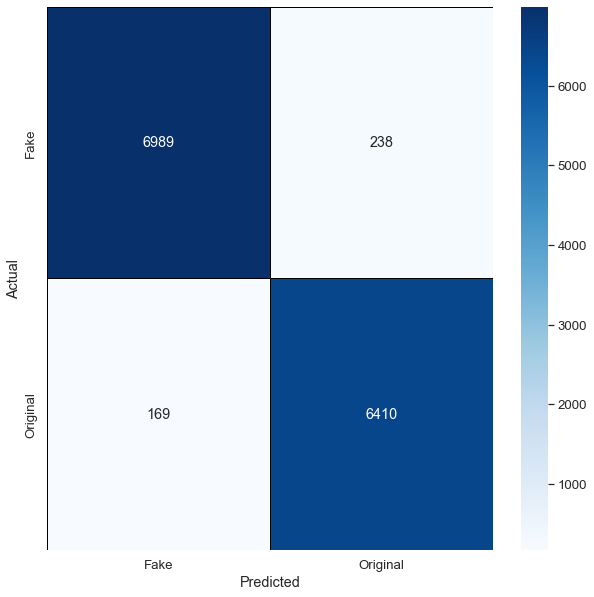

In [58]:
cm = confusion_matrix(y_test, pred)

cm_df = pd.DataFrame(cm, index = ['Fake','Original'] , columns = ['Fake','Original'])

plt.figure(figsize = (10,10))
sns.heatmap(cm_df,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

# CM train

In [60]:
preds2 = model.predict(x_train)
pred2 = (preds2 > 0.5).astype("int32")

print(classification_report(y_train, pred2, target_names = ['Fake','Not Fake']))

1295/1295 [==============================] - 23s 18ms/step
              precision    recall  f1-score   support

        Fake       0.99      0.98      0.98     21538
    Not Fake       0.98      0.98      0.98     19877

    accuracy                           0.98     41415
   macro avg       0.98      0.98      0.98     41415
weighted avg       0.98      0.98      0.98     41415



Text(64.5, 0.5, 'Actual')

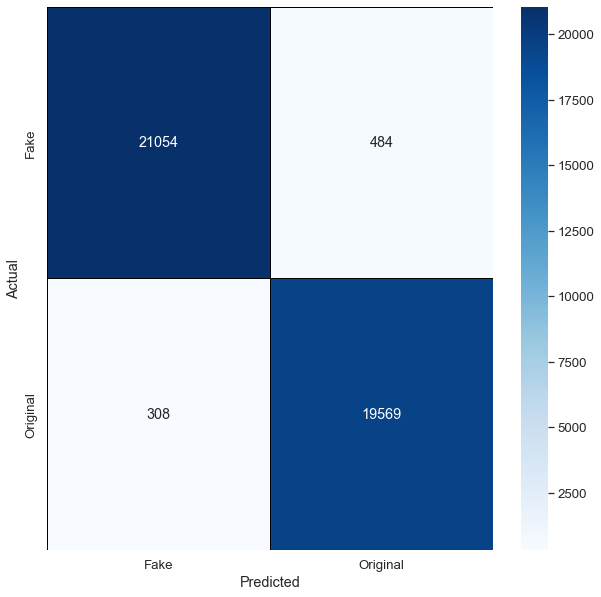

In [61]:
cm = confusion_matrix(y_train, pred2)

cm_df = pd.DataFrame(cm, index = ['Fake','Original'] , columns = ['Fake','Original'])

plt.figure(figsize = (10,10))
sns.heatmap(cm_df,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Test input

In [59]:
# tmp_txt = input('enter news')
tmp_txt = "WASHINGTON (Reuters) head conservative Republican faction U.S. Congress, voted month huge expansion national debt pay tax cuts, called “fiscal conservative” Sunday urged budget restraint 2018. kee..."
tmp_df = pd.Series(tmp_txt)
tmp_df = tmp_df.apply(denoise_text)

def process(tmp_df):
    tokenized_tmp = tokenizer.texts_to_sequences(tmp_df)

    tmp_processed = pad_sequences(tokenized_tmp, maxlen=maxlen)

    predicted = model.predict(tmp_processed)
    print(predicted)

process(tmp_df)

1/1 [==============================] - 0s 16ms/step
[[0.99801564]]
